## Data Wrangling

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import utility
import math

EXPERIEMENT_SEED = 42
np.random.seed(EXPERIEMENT_SEED)

In [3]:
weather_df = utility.get_processed_dataset()
weather_df.head(4)

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01 00:00:00,-1
2020-01-01 00:01:00,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01 00:01:00,-1
2020-01-01 00:02:00,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01 00:02:00,-1
2020-01-01 00:03:00,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,7.70,294.0,806.823,0.0,0.235,0.0,0.0,2020-01-01 00:03:00,-1


### Training Testing Dataset Formatting

In [4]:
def prepare_usable_dataset(dataset, best_feature_cols = None, months = None):

    #Removing non recorded cloud coverages
    
    mask = (dataset.datetime_cpy.dt.month.isin(months) & (dataset['total_cloud_coverage_pct'] > -1)) if months else (dataset['total_cloud_coverage_pct'] > -1)
    #if not months:
    dataset = dataset.loc[mask] #Import full dataset
    #else:
        #dataset =  dataset.loc[dataset.datetime_cpy.dt.month.isin(months) & (dataset['total_cloud_coverage_pct'] > -1)] #Import selected months
    
    if best_feature_cols:
        dataset = pd.concat([dataset[best_feature_cols], dataset[['total_cloud_coverage_pct']]], axis=1)
    
    #Rescaling total_cloud_coverage_pct to percent values
    dataset['total_cloud_coverage_pct'] = dataset['total_cloud_coverage_pct'] / 100
    
    #Drop datetime column if present
    if 'datetime_cpy' in dataset.columns:
        dataset = dataset.drop(['datetime_cpy'], axis=1)

    return dataset

def prepare_daywise_chunked_dataset(dataset):
    np.random.seed(EXPERIEMENT_SEED)
    # map month_daywise mapped dictionary
    month_day_pairs = utility.get_month_day_pairing(dataset)

    dataset_chunked = {}
    min_uptime_duration = np.inf;
    max_uptime_duration = -np.inf;

    for month, day in month_day_pairs:
        daily_chunk = dataset.loc[((dataset.index.month == month) & ( dataset.index.day == day)), :].values
        #TODO: Later Segment active minutes such that only 60 mins spaced time frames are present
        total_daily_active_minutes = np.shape(daily_chunk)[0]
        #Using for max 8 hours of data per day to keep other splits simple
        max_daily_minutes = 8 * 60

        #Segmenting for max 8 hours per day
        dataset_chunked[(month,day)] = daily_chunk[:max_daily_minutes,:]

        if(total_daily_active_minutes < min_uptime_duration):
            min_uptime_duration = total_daily_active_minutes

        if(total_daily_active_minutes > max_uptime_duration):
            max_uptime_duration = total_daily_active_minutes

    print("Shape of a sample day record (8 hours * 60, num_features): {}".format(np.shape(dataset_chunked[next(iter(dataset_chunked))])))
    print("Min-Max Active Uptime in Hours: (%d,%d)\n" % ((min_uptime_duration // 60) ,(max_uptime_duration // 60)))

    dataset_chunked_arr = list(dataset_chunked.items()) 
    
    #Shuffled chunks randomly day wise (Mintues information per day is still intact)
    np.random.shuffle(dataset_chunked_arr)  
    dataset_chunked = dict(dataset_chunked_arr)
    
    print("First Random Three days: ")
    for itr, (key, value) in enumerate(dataset_chunked.items()):
        print(key, end="  ")
        if itr == 2:
            break
    return dataset_chunked


def get_train_test_split(dataset, test_ratio=0.09, best_feature_cols = None, months = None):
    
    dataset = prepare_usable_dataset(dataset, best_feature_cols, months)
    print("Original dataset shape: ", dataset.shape)
    print("----------------------------------------------------------------")
    dataset_chuncked = prepare_daywise_chunked_dataset(dataset)
    print("\n----------------------------------------------------------------")
    dataset = np.array([arr for arr in dataset_chuncked.values()])
    print("Dataset shape after daywise chunks", dataset.shape)
    print("----------------------------------------------------------------")
    #Splitting dataset into train test
    test_size = math.floor(dataset.shape[0] * test_ratio)
    train, test = dataset[:-test_size,:,:] , dataset[-test_size:,:,:]
    print("Data shape with reference format: [num_instances, num_time_steps, num_features]")
    print("Training shape {} , Testing Shape {}".format(train.shape, test.shape))
    
    #Get month,day indexes for train test for debugging
    month_day_wise_indexes = list(dataset_chuncked.keys())
    train_monthdays, test_monthdays = month_day_wise_indexes[:-test_size], month_day_wise_indexes[-test_size:]
    
    return train, test, train_monthdays, test_monthdays

### Standard Scaling 

In [5]:
from sklearn.preprocessing import StandardScaler

def fit_transform_standard_scaler(train_x, test_x = np.array([])):
    scaler = StandardScaler()
    num_instances_train, num_time_steps, num_features = train_x.shape

    train_x = np.reshape(train_x, newshape=(-1, num_features))
    train_x = scaler.fit_transform(train_x)
    train_x = np.reshape(train_x, newshape=(num_instances_train, num_time_steps, num_features))
    
    if test_x.size > 0:
        num_instances_test = test_x.shape[0]
        
        test_x = np.reshape(test_x, newshape=(-1, num_features))
        test_x = scaler.transform(test_x)
        test_x = np.reshape(test_x, newshape=(num_instances_test, num_time_steps, num_features))
    
    return scaler, train_x, test_x

In [6]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM

tf.random.set_seed(EXPERIEMENT_SEED)

weather_models = {}

In [7]:
#Training to find future values 15 minutes ahead given 6 hours of data
# convert history into inputs and outputs
def to_supervised(data, n_input, n_out=15):
    # flatten data
    X, y = list(), list()

    #Make batches of n_input minutes in sequnce in only given day
    for day in range(len(data)):
        in_start = 0

        day_data = data[day, :, :]
        # step over the entire history one time step at a time
        for _ in range(len(day_data)):
            # define the end of the input sequence
            in_end = in_start + n_input
            out_end = in_end + n_out
            # ensure we have enough day_data for this instance
            if out_end <= len(day_data):
                #x_input = day_data[in_start:in_end, -1]  #Univariate - using only last column total_cloud_coverage_pct
                x_input = day_data[in_start:in_end, :]
                #x_input = x_input.reshape((len(x_input), 1))  # IDK why I added this
                X.append(x_input)
                y.append(day_data[in_end:out_end, -1]) #Univariate - using only last column total_cloud_coverage_pct
            # move along one time step
            in_start += 1
    return array(X), array(y)

In [8]:

# Evaluate modle for only 30 minute mark forcasts of the day for each day
# Note: Rescaling evaluations back to (0,100) scale from ratio scale
def evaluate_forecasts_daily_eod_prediction(predicted, actual, days_sampled=1, minutes_marks=[30]):
    
    rmse_scores = list()
    mae_scores = list()
    
    eod_steps = actual.shape[0] // days_sampled
    start = eod_steps - 1
    
    for mark in minutes_marks:
        mark = mark - 1 #Since python indexing starts from 0
        
        # calculate mse 
        mse = mean_squared_error(actual[start : : eod_steps, mark], predicted[start : : eod_steps, mark])
        # calculate rmse
        rmse = sqrt(mse) * 100
        #calculate mae
        mae = mean_absolute_error(actual[start : : eod_steps, mark], predicted[start : : eod_steps, mark]) * 100
        
        rmse_scores.append(rmse)
        mae_scores.append(mae)

    return rmse_scores, mae_scores


In [9]:
def plot_model_evaluation(history, data_x, data_pred_y, data_actual_y, item):
    fig, axes = plt.subplots(ncols=2, figsize=(25,5), gridspec_kw={'width_ratios': [1, 2.5]})
    axes[0].plot(history.history['mae'], label="train_mae")
    axes[0].plot(history.history['val_mae'], label="test_mae")
    axes[0].set_title("Model History", fontsize=16)
    axes[0].legend()


    axes[1].plot(np.concatenate([data_x[item, :, -1].flatten(), data_pred_y[item]]), 'r-', label="Predicted Output")
    axes[1].plot(np.concatenate([data_x[item, :, -1].flatten(), data_actual_y[item]]), 'g-', label="Actual Output")
    axes[1].plot(data_x[item, :, -1].flatten(), 'b-', label="Input")
    axes[1].set_xlabel("Minutes")
    axes[1].set_ylabel("total_cloud_coverage_pct %")
    axes[1].legend()
    axes[1].set_title("Sample Training set input ({} min) and output ({} min) cloud coverage".format(INPUT_DURATION_MINS,PRED_DURATION_MINS), fontsize=16)

    plt.show()

## Import train test dataset

In [12]:
train, test, train_monthdays, test_monthdays = get_train_test_split(weather_df,  test_ratio=0.09, best_feature_cols=None)

C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Original dataset shape:  (252252, 15)
----------------------------------------------------------------
Shape of a sample day record (8 hours * 60, num_features): (480, 15)
Min-Max Active Uptime in Hours: (8,14)

First Random Three days: 
(7, 12)  (2, 3)  (1, 16)  
----------------------------------------------------------------
Dataset shape after daywise chunks (366, 480, 15)
----------------------------------------------------------------
Data shape with reference format: [num_instances, num_time_steps, num_features]
Training shape (334, 480, 15) , Testing Shape (32, 480, 15)


Univariate Training Set size for only 8 hours of data in minutes (57, 480, 15)


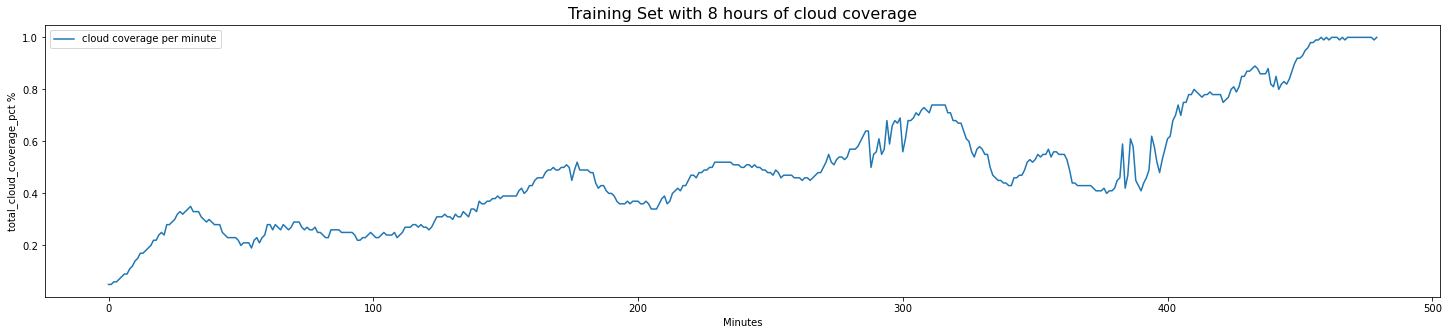

In [11]:
print("Univariate Training Set size for only 8 hours of data in minutes", train.shape)

plt.figure(figsize=(25,5))
plt.plot(train[0, :, -1], label="cloud coverage per minute")
plt.xlabel("Minutes")
plt.ylabel("total_cloud_coverage_pct %")
plt.legend()
plt.title("Training Set with 8 hours of cloud coverage", fontsize=16)
plt.show()